AGRO, ADM, BG, INGR, SANW, FAMI, MGPI, CRESY, CHSCL

#  Trading Renewable Energy Stocks with MEI Models

## Our aim here is to choose our trade position based on MEI - Multivariate ENSO Index. We chose stocks which own renewable energy farms (and not manufacturing devices used for renewable energy). We try modelling MEI using AR / ARIMA / SARIMAX model. Stocks are detrended to focus on seasonality signal by ENSO. We expect to see negative correlation for MEI and stock's price. Hence, based upon model's prediction for future MEI, we choose to short the stock if MEI is >1.5σ (indicating el-nino) and long the stock when MEI recovers <1.25σ . This ensures we have a position that can be comparable to buy & hold while adjusting back positions when climate is suggestive of El-Nino.

## Data Sources

https://psl.noaa.gov/data/correlation/meiv2.csv

https://psl.noaa.gov/data/correlation/oni.csv

# Time Series Analysis for MEI

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

In [ ]:
import warnings
warnings.filterwarnings("ignore",message="Non-invertible starting MA parameters found")

In [ ]:
mei = pd.read_csv('meiv2.csv')
mei['Date'] = pd.to_datetime(mei['Date'], format='%m/%d/%y')
mei = mei.rename(columns={'Multivariate ENSO Index': 'MEI'})
mei

,Date,MEI
0,1979-01-01,0.47
1,1979-02-01,0.29
2,1979-03-01,-0.05
3,1979-04-01,0.21
4,1979-05-01,0.27
...,...,...
550,2024-11-01,-0.68
551,2024-12-01,-0.91
552,2025-01-01,-1.00
553,2025-02-01,-0.83


In [ ]:
mei.set_index('Date', inplace=True)
mei.index.freq = 'MS'

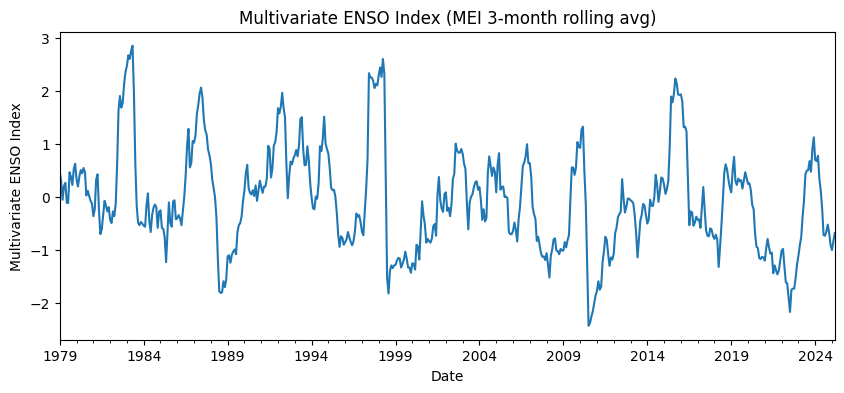

In [ ]:
mei['MEI'].plot(title='Multivariate ENSO Index (MEI 3-month rolling avg)', figsize=(10,4))
plt.ylabel('Multivariate ENSO Index')
plt.show()

In [ ]:
aic_ar = {}
for p in range(1, 13):
    m = AutoReg(mei['MEI'], lags=p, old_names=False).fit()
    aic_ar[p] = m.aic

best_p = min(aic_ar, key=aic_ar.get)
print(f"Best AR({best_p}) by AIC = {aic_ar[best_p]:.2f}")
ar_model = AutoReg(mei['MEI'], lags=best_p, old_names=False).fit()
print(ar_model.summary())

Best AR(6) by AIC = 175.56
                            AutoReg Model Results                             
Dep. Variable:                    MEI   No. Observations:                  555
Model:                     AutoReg(6)   Log Likelihood                 -79.778
Method:               Conditional MLE   S.D. of innovations              0.280
Date:                Tue, 03 Jun 2025   AIC                            175.556
Time:                        04:28:24   BIC                            210.021
Sample:                    07-01-1979   HQIC                           189.025
                         - 03-01-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.012     -0.462      0.644      -0.029       0.018
MEI.L1         1.4418      0.042     33.986      0.000       1.359       1.525
MEI.L2        -0.8211    

In [ ]:
bic_ar = {}
for p in range(1, 13):
    m = AutoReg(mei['MEI'], lags=p, old_names=False).fit()
    bic_ar[p] = m.bic

# find the p with smallest BIC
best_p_bic = min(bic_ar, key=bic_ar.get)
print(f"Best AR({best_p_bic}) by BIC = {bic_ar[best_p_bic]:.2f}")

# fit & summarize
ar_model_bic = AutoReg(mei['MEI'], lags=best_p_bic, old_names=False).fit()
print(ar_model_bic.summary())


Best AR(4) by BIC = 207.67
                            AutoReg Model Results                             
Dep. Variable:                    MEI   No. Observations:                  555
Model:                     AutoReg(4)   Log Likelihood                 -84.902
Method:               Conditional MLE   S.D. of innovations              0.282
Date:                Tue, 03 Jun 2025   AIC                            181.803
Time:                        04:28:24   BIC                            207.673
Sample:                    05-01-1979   HQIC                           191.912
                         - 03-01-2025                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0061      0.012     -0.508      0.612      -0.030       0.018
MEI.L1         1.4072      0.041     34.253      0.000       1.327       1.488
MEI.L2        -0.7339    

In [ ]:
# 3) ARIMA(p,d,q) grid search by AIC
aic_ari = {}
for p in range(3):
    for d in [0,1]:
        for q in range(3):
            m = ARIMA(mei['MEI'], order=(p,d,q), enforce_stationarity=True, enforce_invertibility=True).fit()
            aic_ari[(p,d,q)] = m.aic

best_ari = min(aic_ari, key=aic_ari.get)
print(f"\nBest ARIMA{best_ari} by AIC = {aic_ari[best_ari]:.2f}")
ari_model = ARIMA(mei['MEI'], order=best_ari).fit()
print(ari_model.summary())


Best ARIMA(2, 0, 2) by AIC = 186.80
                               SARIMAX Results                                
Dep. Variable:                    MEI   No. Observations:                  555
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 -87.401
Date:                Tue, 03 Jun 2025   AIC                            186.802
Time:                        04:28:39   BIC                            212.716
Sample:                    01-01-1979   HQIC                           196.925
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0639      0.121     -0.529      0.597      -0.301       0.173
ar.L1          1.8340      0.069     26.711      0.000       1.699       1.969
ar.L2         -

In [ ]:
# ARIMA by BIC
bic_ari = {}
for p in range(3):
    for d in (0,1):
        for q in range(3):
            m = ARIMA(mei['MEI'], order=(p,d,q),
                        enforce_stationarity=True,
                        enforce_invertibility=True).fit()
            bic_ari[(p,d,q)] = m.bic

best_ari_bic = min(bic_ari, key=bic_ari.get)
print("Best ARIMA by BIC:", best_ari_bic, bic_ari[best_ari_bic])

Best ARIMA by BIC: (1, 0, 1) 205.05668520220212


In [ ]:
ari_model_bic = ARIMA(mei['MEI'], order=best_ari_bic).fit()
print(ari_model_bic.summary())

                               SARIMAX Results                                
Dep. Variable:                    MEI   No. Observations:                  555
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -89.890
Date:                Tue, 03 Jun 2025   AIC                            187.781
Time:                        04:28:56   BIC                            205.057
Sample:                    01-01-1979   HQIC                           194.529
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0651      0.185     -0.352      0.725      -0.428       0.297
ar.L1          0.8903      0.018     49.001      0.000       0.855       0.926
ma.L1          0.5944      0.030     20.042      0.0

In [ ]:
# 4) SARIMAX seasonal grid by AIC
aic_sx = {}
pdq_choices = [(1,0,1), (0,1,1), (1,1,1)]
seasonal_choices = [(1,0,1,12), (0,1,1,12), (1,1,1,12)]
for pdq in pdq_choices:
    for s in seasonal_choices:
        m = SARIMAX(mei['MEI'], order=pdq, seasonal_order=s,
                    enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        aic_sx[(pdq,s)] = m.aic

best_sx = min(aic_sx, key=aic_sx.get)
print(f"\nBest SARIMAX{best_sx} by AIC = {aic_sx[best_sx]:.2f}")
sx_model = SARIMAX(mei['MEI'], order=best_sx[0], seasonal_order=best_sx[1],
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
print(sx_model.summary())


Best SARIMAX((1, 0, 1), (1, 0, 1, 12)) by AIC = 185.79
                                     SARIMAX Results                                      
Dep. Variable:                                MEI   No. Observations:                  555
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -87.895
Date:                            Tue, 03 Jun 2025   AIC                            185.790
Time:                                    04:29:08   BIC                            207.257
Sample:                                01-01-1979   HQIC                           194.185
                                     - 03-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8952      0.018     48.417      0.000    

In [ ]:
# SARIMAX by BIC
bic_sx = {}
for pdq in pdq_choices:
    for seas in seasonal_choices:
        m = SARIMAX(mei['MEI'],
                    order=pdq,
                    seasonal_order=seas,
                    enforce_stationarity=True,
                    enforce_invertibility=True).fit(disp=False)
        bic_sx[(pdq, seas)] = m.bic

best_sx_bic = min(bic_sx, key=bic_sx.get)
print("Best SARIMAX by BIC:", best_sx_bic, bic_sx[best_sx_bic])

Best SARIMAX by BIC: ((1, 0, 1), (1, 0, 1, 12)) 208.45663989135068


In [ ]:
sx_model_bic = SARIMAX(mei['MEI'], order=best_sx_bic[0], seasonal_order=best_sx_bic[1],
                   enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
print(sx_model_bic.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                MEI   No. Observations:                  555
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 -87.895
Date:                            Tue, 03 Jun 2025   AIC                            185.790
Time:                                    04:29:29   BIC                            207.257
Sample:                                01-01-1979   HQIC                           194.185
                                     - 03-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8952      0.018     48.417      0.000       0.859       0.931
ma.L1          0.5881      0.030   

In [ ]:
# 5) Holt–Winters additive seasonal
hw_model = ExponentialSmoothing(mei['MEI'], trend='add',
                                seasonal='add', seasonal_periods=12).fit()
print(f"\nHolt–Winters SSE = {hw_model.sse:.2f}")


Holt–Winters SSE = 58.32


In [ ]:
# 6) Conclusion
print("\nConclusion:")
print(f"- AR({best_p}) AIC = {aic_ar[best_p]:.2f}")
print(f"- ARIMA{best_ari} AIC = {aic_ari[best_ari]:.2f}")
print(f"- SARIMAX{best_sx} AIC = {aic_sx[best_sx]:.2f}")
print("By BIC")
print(f"- AR({best_p_bic}) BIC = {bic_ar[best_p_bic]:.2f}")
print(f"- ARIMA{best_ari_bic} BIC = {bic_ari[best_ari_bic]:.2f}")
print(f"- SARIMAX{best_sx_bic} BIC = {bic_sx[best_sx_bic]:.2f}")
print(f"- Holt–Winters SSE = {hw_model.sse:.2f}")


Conclusion:
- AR(6) AIC = 175.56
- ARIMA(2, 0, 2) AIC = 186.80
- SARIMAX((1, 0, 1), (1, 0, 1, 12)) AIC = 185.79
By BIC
- AR(4) BIC = 207.67
- ARIMA(1, 0, 1) BIC = 205.06
- SARIMAX((1, 0, 1), (1, 0, 1, 12)) BIC = 208.46
- Holt–Winters SSE = 58.32


In [ ]:
# AIC based DW and Breusch–Godfrey LM Test
fitted = {
    'AR':       ar_model,
    'ARIMA':    ari_model,
    'SARIMAX':  sx_model
}

for name, res in fitted.items():
    print(f"\n=== {name} Model ===")

    # 1) Durbin–Watson
    dw = durbin_watson(res.resid)
    print(f"Durbin–Watson statistic: {dw:.3f}")
    if    dw < 1.8:
        dw_interp = "strong positive autocorrelation"
    elif  dw > 2.2:
        dw_interp = "strong negative autocorrelation"
    else:
        dw_interp = "little to no autocorrelation"
    print("  → Interpretation:", dw_interp)

    # 2) Breusch–Godfrey LM test
    #    nlags=12 for monthly data
    lm_stat, lm_pvalue, _, _ = acorr_breusch_godfrey(res, nlags=12)
    print(f"Breusch–Godfrey LM stat: {lm_stat:.2f}, p‐value: {lm_pvalue:.3f}")
    if lm_pvalue < 0.05:
        bg_interp = "reject H0 → residual autocorrelation present"
    else:
        bg_interp = "fail to reject H0 → no evidence of autocorrelation"
    print("  → Interpretation:", bg_interp)



=== AR Model ===
Durbin–Watson statistic: 2.003
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 5.84, p‐value: 0.924
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== ARIMA Model ===
Durbin–Watson statistic: 2.120
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 14.67, p‐value: 0.260
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== SARIMAX Model ===
Durbin–Watson statistic: 2.078
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 16.67, p‐value: 0.163
  → Interpretation: fail to reject H0 → no evidence of autocorrelation


In [ ]:
# BIC based DW and Breusch–Godfrey LM Test
fitted = {
    'AR':       ar_model_bic,
    'ARIMA':    ari_model_bic,
    'SARIMAX':  sx_model_bic
}

for name, res in fitted.items():
    print(f"\n=== {name} Model ===")

    # 1) Durbin–Watson
    dw = durbin_watson(res.resid)
    print(f"Durbin–Watson statistic: {dw:.3f}")
    if    dw < 1.8:  dw_interp = "strong positive autocorrelation"
    elif  dw > 2.2:  dw_interp = "strong negative autocorrelation"
    else:            dw_interp = "little to no autocorrelation"
    print("  → Interpretation:", dw_interp)

    # 2) Breusch–Godfrey LM test
    #    nlags=12 for monthly data
    lm_stat, lm_pvalue, _, _ = acorr_breusch_godfrey(res, nlags=12)
    print(f"Breusch–Godfrey LM stat: {lm_stat:.2f}, p‐value: {lm_pvalue:.3f}")
    if lm_pvalue < 0.05:
        bg_interp = "reject H0 → residual autocorrelation present"
    else:
        bg_interp = "fail to reject H0 → no evidence of autocorrelation"
    print("  → Interpretation:", bg_interp)


=== AR Model ===
Durbin–Watson statistic: 1.950
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 16.91, p‐value: 0.153
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== ARIMA Model ===
Durbin–Watson statistic: 2.074
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 11.91, p‐value: 0.453
  → Interpretation: fail to reject H0 → no evidence of autocorrelation

=== SARIMAX Model ===
Durbin–Watson statistic: 2.078
  → Interpretation: little to no autocorrelation
Breusch–Godfrey LM stat: 16.67, p‐value: 0.163
  → Interpretation: fail to reject H0 → no evidence of autocorrelation


### AR(6) and SARIMAX((1, 0, 1), (1, 0, 1, 12)) are best chosen models